In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import glob
import re
import math
from time import time
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard, CSVLogger#, LearningRateScheduler
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
#from sklearn.datasets import make_multilabel_classification
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten
# import tensorflow_hub as hub
from sklearn.metrics import mean_absolute_error,mean_squared_error
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
from model8 import model
import argparse
import gc
import random

In [ ]:
# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
weight_dir = '/content/drive/MyDrive/weights_C3D_sports1M_tf.h5'

In [ ]:
def calculate_mean_std(x, channels_first=False, verbose=0):
    """
    Calculates channel-wise mean and std
    
    Parameters
    ----------
    x : array
        Array representing a collection of images (frames) or
        collection of collections of images (frames) - namely video
    channels_first : bool, optional
        Leave False, by default False
    verbose : int, optional
        1-prints out details, 0-silent mode, by default 0
    
    Returns
    -------
    array of shape [2, num_channels]
        Array with per channel mean and std for all the frames
    """
    ndim = x.ndim
    assert ndim in [5,4]
    assert channels_first == False
    all_mean = []
    all_std = []    
    num_channels = x.shape[-1]
    
    for c in range(0, num_channels):
        if ndim ==5: # videos
            mean = x[:,:,:,:,c].mean()
            std = x[:,:,:,:,c].std()
        elif ndim ==4: # images rgb or grayscale
            mean = x[:,:,:,c].mean()
            std = x[:,:,:,c].std()
        if verbose:
            print("Channel %s mean before: %s" % (c, mean))   
            print("Channel %s std before: %s" % (c, std))
            
        all_mean.append(mean)
        all_std.append(std)
    
    return np.stack((all_mean, all_std))


def preprocess_input(x, mean_std, divide_std=False, channels_first=False, verbose=0):
    """
    Channel-wise substraction of mean from the input and optional division by std
    
    Parameters
    ----------
    x : array
        Input array of images (frames) or videos
    mean_std : array
        Array of shape [2, num_channels] with per-channel mean and std
    divide_std : bool, optional
        Add division by std or not, by default False
    channels_first : bool, optional
        Leave False, otherwise not implemented, by default False
    verbose : int, optional
        1-prints out details, 0-silent mode, by default 0
    
    Returns
    -------
    array
        Returns input array after applying preprocessing steps
    """
    x = np.asarray(x, dtype=np.float32)    
    ndim = x.ndim
    assert ndim in [5,4]
    assert channels_first == False
    num_channels = x.shape[-1]
    
    for c in range(0, num_channels):  
        if ndim ==5: # videos
            x[:,:,:,:,c] -= mean_std[0][c]
            if divide_std:
                x[:,:,:,:,c] /= mean_std[1][c]
            if verbose:
                print("Channel %s mean after preprocessing: %s" % (c, x[:,:,:,:,c].mean()))    
                print("Channel %s std after preprocessing: %s" % (c, x[:,:,:,:,c].std()))
        elif ndim ==4: # images rgb or grayscale
            x[:,:,:,c] -= mean_std[0][c]
            if divide_std:
                x[:,:,:,c] /= mean_std[1][c]
            if verbose:        
                print("Channel %s mean after preprocessing: %s" % (c, x[:,:,:,c].mean()))    
                print("Channel %s std after preprocessing: %s" % (c, x[:,:,:,c].std()))            
    return x


In [ ]:
files = glob.glob('/content/drive/MyDrive/training_arr/*.avi')
files_val = glob.glob('/content/drive/MyDrive/validation_arr/*.avi')
print(str(files[5]))
print(str(files_val[5]))

training_labels = []
training_files = []
val_labels = []
val_files = []

unseen = ['recieve']

/content/drive/MyDrive/training_arr/teacher9763_clipped.avi
/content/drive/MyDrive/validation_arr/chicken2744_clipped.avi


In [ ]:
for file in files:
    label = re.findall('[A-Za-z]+[0-9]',str(file))[0][:-1]
    training_labels.append(label)
    training_files.append(str(file))

for file in files_val:
    label = re.findall('[A-Za-z]+[0-9]',str(file))[0][:-1]
    val_labels.append(label)
    val_files.append(str(file))


In [ ]:
training_data = pd.DataFrame({'filename':training_files,'training_labels':training_labels})
val_data = pd.DataFrame({'filename':val_files,'val_labels':val_labels})
val_data = val_data[val_data['val_labels']!= 'receive']

label_encoder = LabelEncoder()

training_data['encoded_labels'] = label_encoder.fit_transform(training_data['training_labels'])
val_data['encoded_labels'] = label_encoder.transform(val_data['val_labels'])
training_data.to_csv('training_words.csv')
val_data.to_csv('val_words.csv')

training_counts = training_data['encoded_labels'].value_counts().reset_index()
training_counts.columns = ['encoded_labels','value_counts']
training_data = pd.merge(left=training_data,right=training_counts,how='left',left_on=['encoded_labels'],right_on=['encoded_labels'])
training_data = training_data[training_data['value_counts'] >= 12]
training_data_labels = training_data['encoded_labels'].tolist()
val_data = val_data[val_data['encoded_labels'].isin(training_data_labels)]
val_data_labels = val_data['encoded_labels'].tolist()
training_data = training_data[training_data['encoded_labels'].isin(val_data_labels)]
print(training_data['encoded_labels'].nunique())
print(set([x for x in training_data_labels if x not in val_data_labels]))
print(training_data['encoded_labels'].nunique())
print(val_data['encoded_labels'].nunique())
label_encoder = LabelEncoder()
training_data['encoded_labels'] = label_encoder.fit_transform(training_data['training_labels'])
val_data['encoded_labels'] = label_encoder.transform(val_data['val_labels'])
print(training_data['encoded_labels'].nunique())
print(val_data['encoded_labels'].nunique())

199
{255}
199
199
199
199


In [ ]:
videos_data = []


In [ ]:
# i=1

# for file in training_data['filename']:
    
    
#     resize=(112, 112)
#     if i%100 == 0:
#       print(i)
#       print(str(file))

#     cap = cv2.VideoCapture(str(file))
#     ret = True
#     frames=[]

#     while ret == True:
#         ret,frame = cap.read()
#         if ret == True:
#             frame = cv2.resize(frame,resize)
#             frames.append(frame)
        
#     video = np.stack(frames,axis=0)
#     frames,length,width,channels = video.shape


#     video = video[list(np.linspace(0,frames-1,16,dtype=int))]
    
#     mean_std = calculate_mean_std(video, channels_first=False, verbose=0)
#     video = preprocess_input(video, mean_std, divide_std=False, channels_first=False, verbose=0)
#     videos_data.append(video)
#     cap.release()
#     i += 1
    

# cv2.destroyAllWindows()

In [ ]:
def gen_video_prep(file_loc, size):

    resize = size

    cap = cv2.VideoCapture(str(file_loc))
    ret = True
      
    frames=[]

    while ret == True:
        ret, frame = cap.read()
        if ret == True:
            frame = cv2.resize(frame,resize)
            # num = np.random.randint(0,100)
            # if num < 20:
            #     frame = np.flip(frame,axis=1)
            #     frame=frame
            frames.append(frame)
          
    video = np.stack(frames,axis=0)
    frames, channels = video.shape[0], video.shape[3]

    frame_total = 16
    if frames >= frame_total:
        frame_list = list(range(0,frames))
        random.shuffle(frame_list)
        frame_list = frame_list[:frame_total]
        frame_list.sort(reverse = False)
    else:
        frame_list = list(np.linspace(0,frames-1,frame_total,dtype=int))

    #video = video[list(np.linspace(0,frames-1,16,dtype=int))]
    video = video[frame_list]

    mean_std = calculate_mean_std(video, channels_first=False, verbose=0)

    video = preprocess_input(video, mean_std, divide_std=False, channels_first=False, verbose=0)

    cap.release()
      

    cv2.destroyAllWindows()
  
    return video

In [ ]:
def val_preprocess(files, size):
    
    vids = []

    i = 1
    for file in files:
    
        resize = size

        if i%100 == 0:
            print(i)
            print(str(file))

        cap = cv2.VideoCapture(str(file))
        ret = True
        
        frames=[]

        while ret == True:
            ret, frame = cap.read()
            if ret == True:
                frame = cv2.resize(frame,resize)
                #frame = frame
                frames.append(frame)
        
        
        video = np.stack(frames,axis=0)
        frames, channels = video.shape[0], video.shape[3]

        frame_total = 16
        if frames >= frame_total:
            frame_list = list(range(0,frames))
            random.shuffle(frame_list)
            frame_list = frame_list[:frame_total]
            frame_list.sort(reverse = False)
        else:
            frame_list = list(np.linspace(0,frames-1,frame_total,dtype=int))

        #video = video[list(np.linspace(0,frames-1,16,dtype=int))]
        video = video[frame_list]

        mean_std = calculate_mean_std(video, channels_first=False, verbose=0)

        video = preprocess_input(video, mean_std, divide_std=False, channels_first=False, verbose=0)
        vids.append(video)

        i += 1

        cap.release()
        

        cv2.destroyAllWindows()
    
    return vids

In [ ]:
gen_video_prep(val_data['filename'].iloc[15], (112,112))

array([[[[-46.66101  , -19.969383 , -11.320587 ],
         [-46.66101  , -19.969383 , -11.320587 ],
         [-46.66101  , -19.969383 , -11.320587 ],
         ...,
         [-63.66101  , -51.969383 , -59.320587 ],
         [-55.66101  , -43.969383 , -51.320587 ],
         [-24.66101  , -12.969383 , -20.320587 ]],

        [[-46.66101  , -19.969383 , -11.320587 ],
         [-46.66101  , -19.969383 , -11.320587 ],
         [-46.66101  , -19.969383 , -11.320587 ],
         ...,
         [-63.66101  , -51.969383 , -59.320587 ],
         [-39.66101  , -27.969383 , -35.320587 ],
         [-55.66101  , -43.969383 , -51.320587 ]],

        [[-46.66101  , -19.969383 , -11.320587 ],
         [-46.66101  , -19.969383 , -11.320587 ],
         [-46.66101  , -19.969383 , -11.320587 ],
         ...,
         [-61.66101  , -49.969383 , -57.320587 ],
         [-22.66101  , -10.969383 , -18.320587 ],
         [-72.66101  , -60.969383 , -68.32059  ]],

        ...,

        [[146.33899  , 145.03061  , 10

In [ ]:
val_preprocess(val_data['filename'].iloc[15:16], (112,112))

[array([[[[-48.42141   , -23.154648  , -14.594925  ],
          [-47.42141   , -22.154648  , -13.594925  ],
          [-46.42141   , -21.154648  , -12.594925  ],
          ...,
          [-69.42141   , -54.154648  , -62.594925  ],
          [-52.42141   , -42.154648  , -49.594925  ],
          [-16.42141   ,  -8.154648  , -15.594925  ]],
 
         [[-47.42141   , -22.154648  , -13.594925  ],
          [-47.42141   , -22.154648  , -13.594925  ],
          [-46.42141   , -21.154648  , -12.594925  ],
          ...,
          [-70.42141   , -55.154648  , -63.594925  ],
          [-33.42141   , -23.154648  , -30.594925  ],
          [-58.42141   , -50.154648  , -57.594925  ]],
 
         [[-47.42141   , -22.154648  , -13.594925  ],
          [-47.42141   , -22.154648  , -13.594925  ],
          [-45.42141   , -20.154648  , -11.594925  ],
          ...,
          [-67.42141   , -52.154648  , -60.594925  ],
          [-22.42141   , -12.154648  , -19.594925  ],
          [-67.42141   , -59.15

In [ ]:
test_vid = gen_video_prep(training_data['filename'].iloc[0], (112, 112))

In [ ]:
test_vid.shape

(16, 112, 112, 3)

In [ ]:
# for step in range(num_steps):
#     # Pick an offset within the training data, which has been randomized.
#     # Note: we could use better randomization across epochs.
#     offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

#     # Generate a minibatch.
#     batch_data = train_dataset[offset:(offset + batch_size), :]
#     batch_labels = train_labels[offset:(offset + batch_size), :]

#     # Prepare a dictionary telling the session where to feed the minibatch.
#     # The key of the dictionary is the placeholder node of the graph to be fed,
#     # and the value is the numpy array to feed to it.
#     feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}

class My_Custom_Generator(tf.keras.utils.Sequence) :
  
  def __init__(self, video_filenames, labels, batch_size) :
      self.video_filenames = video_filenames
      self.labels = labels
      self.batch_size = batch_size
    
    
  def __len__(self) :
      return (np.ceil(len(self.video_filenames) / float(self.batch_size))).astype(np.int)
  
  
  def __getitem__(self, idx) :
      batch_x = self.video_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
      batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    
      return np.array([
              gen_video_prep(file_name, (112, 112)) for file_name in batch_x]), np.array(batch_y)

In [ ]:
# with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
#   conv_model = model(weight_dir, trainable = True, freeze_layer = 0)
#   conv_model = conv_model.retrainable_model((3, 3, 3), (16, 112, 112, 3))
#   conv_model.summary()
#   conv_model.compile(optimizer='adam',
#                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                 metrics=['sparse_categorical_accuracy'])



In [ ]:
# conv_model = conv_model.retrainable_model((3, 3, 3), (16, 112, 112, 3))
# conv_model.summary()



In [ ]:
conv_model = model(weight_dir, trainable = True, freeze_layer = 0)
conv_model = conv_model.retrainable_model((3, 3, 3), (16, 112, 112, 3))
conv_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv3D)               (None, 16, 112, 112, 64)  5248      
_________________________________________________________________
Pool1 (MaxPooling3D)         (None, 16, 56, 56, 64)    0         
_________________________________________________________________
Conv2 (Conv3D)               (None, 16, 56, 56, 128)   221312    
_________________________________________________________________
Pool2 (MaxPooling3D)         (None, 8, 28, 28, 128)    0         
_________________________________________________________________
Conv3a (Conv3D)              (None, 8, 28, 28, 256)    884992    
_________________________________________________________________
Conv3b (Conv3D)              (None, 8, 28, 28, 256)    1769728   
_________________________________________________________________
Pool3 (MaxPooling3D)         (None, 4, 14, 14, 256)    0

In [ ]:
y = np.asarray(training_data['encoded_labels'].values)
y_val = np.asarray(val_data['encoded_labels'].values)
len(set(y_val))

199

In [ ]:
print(y.shape)
y = to_categorical(y)
print(y.shape)
y_val = to_categorical(y_val)
print(y_val.shape)


(4581,)
(4581, 199)
(918, 199)


In [ ]:
gen = My_Custom_Generator(training_data['filename'].tolist(), y, 32)
val_imgs = val_preprocess(val_data['filename'].tolist(), (112,112))

100
/content/drive/MyDrive/validation_arr/father3350_clipped.avi
200
/content/drive/MyDrive/validation_arr/hello3464_clipped.avi
300
/content/drive/MyDrive/validation_arr/meet1208_clipped.avi
400
/content/drive/MyDrive/validation_arr/orange1110_clipped.avi
500
/content/drive/MyDrive/validation_arr/see2541_clipped.avi
600
/content/drive/MyDrive/validation_arr/teach2287_clipped.avi
700
/content/drive/MyDrive/validation_arr/water752_clipped.avi
800
/content/drive/MyDrive/validation_arr/always3178_clipped.avi
900
/content/drive/MyDrive/validation_arr/can1982_clipped.avi


In [ ]:
# tf.config.run_functions_eagerly(True)

In [ ]:
model_path = '/content/drive/MyDrive/model'
log_path = '/content/drive/MyDrive/model_log' 
model_name = 'lewis_image_weights.best.{epoch:03d}-{accuracy:.4f}.hdf5'
tb_path = '/content/drive/MyDrive/tb_logs'

In [ ]:
# def scheduler(epoch, lr):

#     if epoch < 50:
#         return lr
#     elif epoch == 50:
#         return lr*0.2
#     elif epoch == 75:
#         return lr*0.5
#     elif epoch == 100:
#         return lr*0.2
#     elif epoch == 125:
#         return lr*0.5
#     elif epoch == 150:
#         return lr*0.2

In [ ]:
callbacks = [
    ModelCheckpoint(
        filepath = os.path.join(model_path, model_name),
        monitor = 'val_accuracy', 
        save_best_only = True, 
        mode = 'max'
        ),

    CSVLogger(
        filename=os.path.join(log_path, 'log.csv'), 
        separator = ',', 
        append = True
        ),

    EarlyStopping(
        monitor = 'val_loss',
        patience = 150
        ),

    TensorBoard(
        log_dir = tb_path,
        histogram_freq = 10,
        write_graph = True,
        write_images = True,
        write_steps_per_second = False,
        update_freq = 'epoch',
        profile_batch = 0,
        embeddings_freq = 0,
        embeddings_metadata = None
        )#,

    # LearningRateScheduler(
    #     schedule = scheduler
    #     ),
    ]



In [ ]:
pd.options.display.max_rows = 300

In [ ]:
#K.set_value(conv_model.optimizer.lr, 0.001) # 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4

In [ ]:
start = time()
conv_model.fit(gen,epochs=400,batch_size=32,callbacks=callbacks,validation_data=(np.asarray(val_imgs),np.asarray(y_val)))
print(time()-start)

Epoch 1/400
144/144 [==============================] - 3857s 27s/step - loss: 5.2938 - accuracy: 0.0048 - val_loss: 5.2930 - val_accuracy: 0.0131
Epoch 2/400
144/144 [==============================] - 127s 879ms/step - loss: 5.2934 - accuracy: 0.0050 - val_loss: 5.2929 - val_accuracy: 0.0120
Epoch 3/400
144/144 [==============================] - 128s 888ms/step - loss: 5.2933 - accuracy: 0.0057 - val_loss: 5.2927 - val_accuracy: 0.0109
Epoch 4/400
144/144 [==============================] - 127s 882ms/step - loss: 5.2931 - accuracy: 0.0068 - val_loss: 5.2926 - val_accuracy: 0.0109
Epoch 5/400
144/144 [==============================] - 127s 881ms/step - loss: 5.2930 - accuracy: 0.0048 - val_loss: 5.2925 - val_accuracy: 0.0087
Epoch 6/400
144/144 [==============================] - 127s 880ms/step - loss: 5.2928 - accuracy: 0.0063 - val_loss: 5.2924 - val_accuracy: 0.0087
Epoch 7/400
144/144 [==============================] - 127s 881ms/step - loss: 5.2922 - accuracy: 0.0065 - val_loss: 5.

In [ ]:
new_model = load_model('/content/drive/MyDrive/model/weights.best.014-0.6306.hdf5')
'/content/drive/MyDrive/model/weights.best.014-0.6306.hdf5'

'/content/drive/MyDrive/model/weights.best.014-0.6306.hdf5'

In [ ]:
#new_model.fit(gen,epochs=400,batch_size=32,callbacks=callbacks,validation_data=(np.asarray(val_imgs),np.asarray(y_val)))

Epoch 1/400
167/167 [==============================] - 165s 986ms/step - loss: 2.8841 - accuracy: 0.3638 - val_loss: 6.0468 - val_accuracy: 0.0184
Epoch 2/400
167/167 [==============================] - 166s 990ms/step - loss: 2.7332 - accuracy: 0.3827 - val_loss: 6.0872 - val_accuracy: 0.0184
Epoch 3/400
167/167 [==============================] - 164s 983ms/step - loss: 2.7189 - accuracy: 0.3878 - val_loss: 6.0325 - val_accuracy: 0.0210
Epoch 4/400
167/167 [==============================] - 165s 989ms/step - loss: 2.6391 - accuracy: 0.4026 - val_loss: 6.0989 - val_accuracy: 0.0193
Epoch 5/400
167/167 [==============================] - 165s 984ms/step - loss: 2.5959 - accuracy: 0.4150 - val_loss: 6.1052 - val_accuracy: 0.0210
Epoch 6/400
167/167 [==============================] - 164s 983ms/step - loss: 2.5450 - accuracy: 0.4159 - val_loss: 6.0704 - val_accuracy: 0.0210
Epoch 7/400
167/167 [==============================] - 165s 985ms/step - loss: 2.4985 - accuracy: 0.4270 - val_loss: 6

In [ ]:
#new_model.summary()

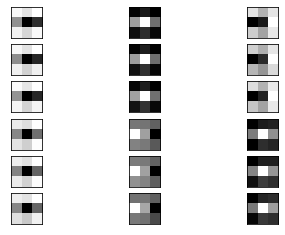

In [ ]:
from matplotlib import pyplot

# retrieve weights from the 3rd Conv3D layer
filters, biases = new_model.layers[0].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
# n_filters = outgoing channels
outgoing_channels = 2
n_filters, ix = outgoing_channels, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, :, i]
    # plot each channel separately
    # Range of incoming channels
    incoming_channels = 3
    for j in range(incoming_channels):
        # Range of Depth of the kernel .i.e. 3
        Depth = 3
        for k in range(Depth):
            #pyplot.figure(figsize=(20,9))
            # specify subplot and turn of axis
            ax = pyplot.subplot((outgoing_channels*3), incoming_channels, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            pyplot.imshow(f[:, :, k,j], cmap='gray')
            ix += 1
# show the figure

pyplot.show()

KerasTensor(type_spec=TensorSpec(shape=(None, 16, 112, 112, 3), dtype=tf.float32, name='Conv1_input'), name='Conv1_input', description="created by layer 'Conv1_input'")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


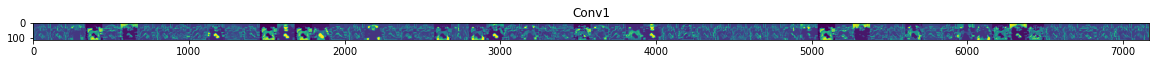

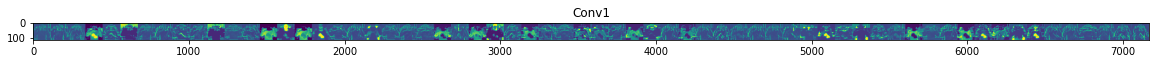

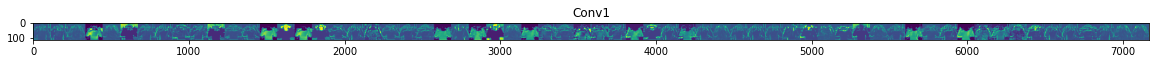

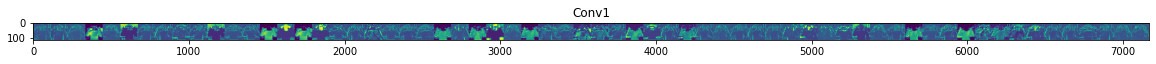

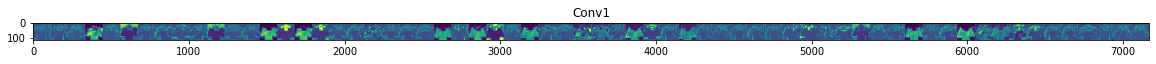

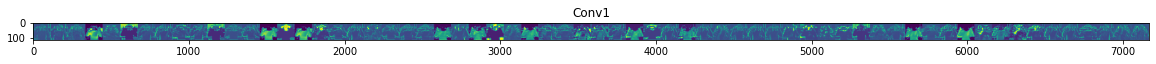

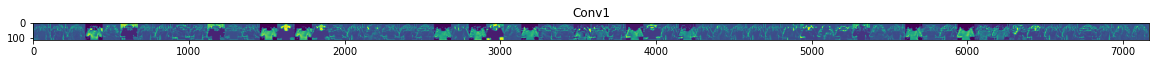

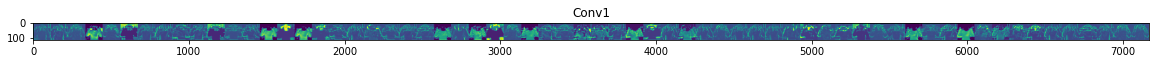

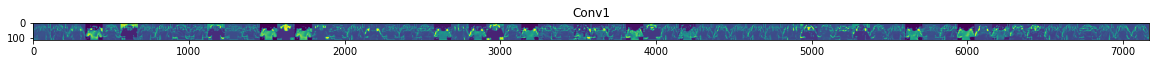

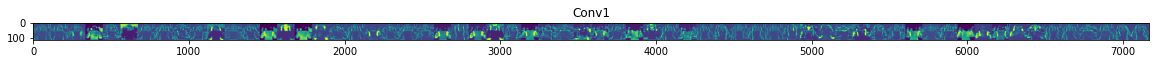

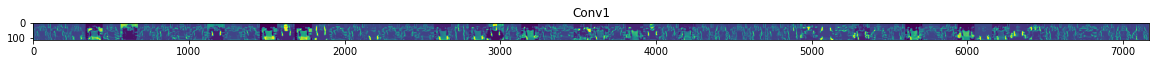

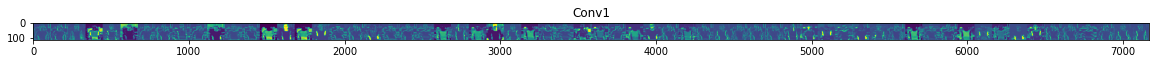

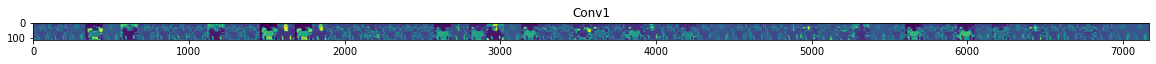

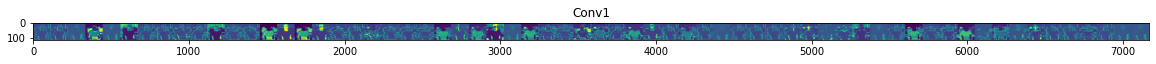

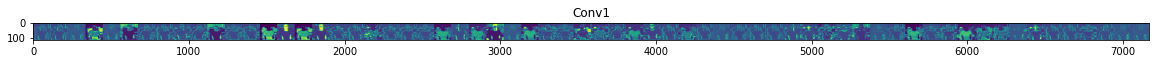

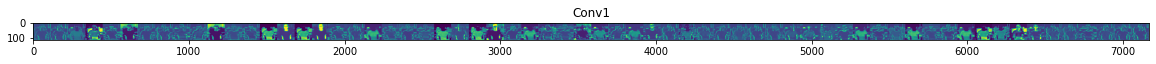

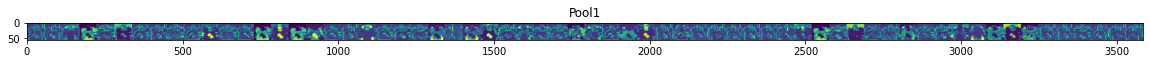

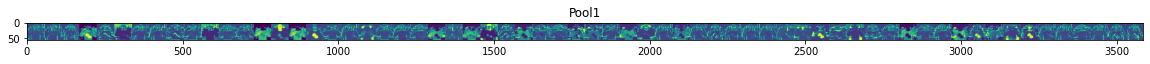

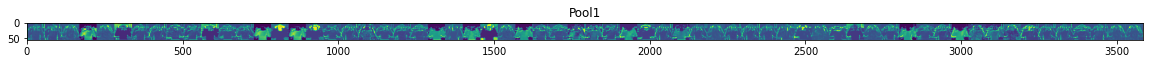

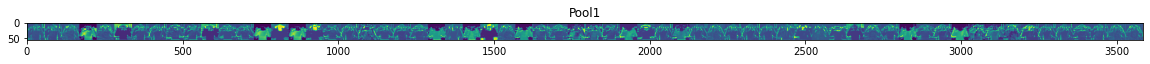

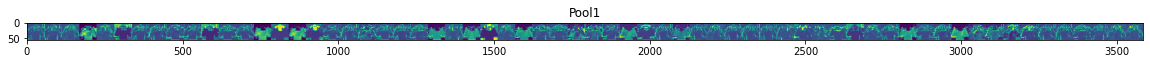

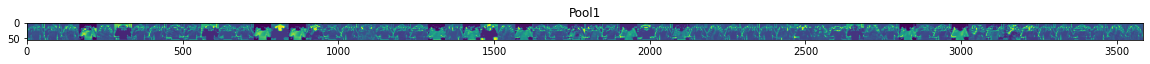

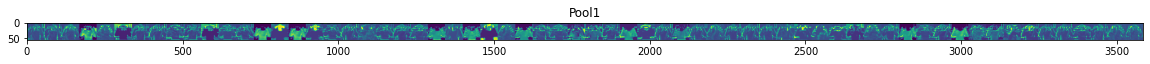

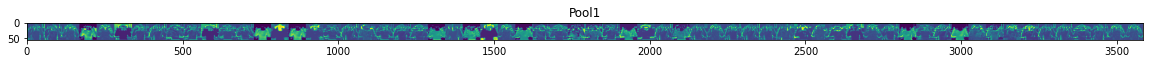

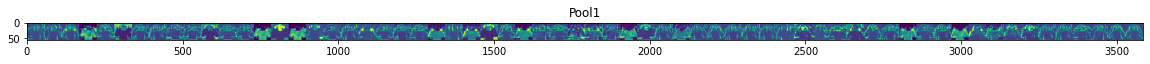

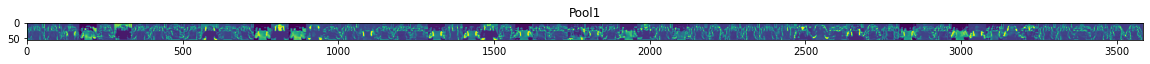

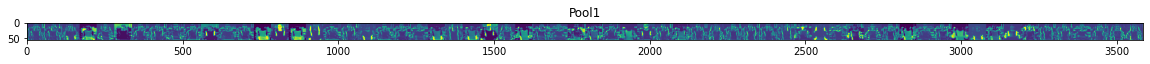

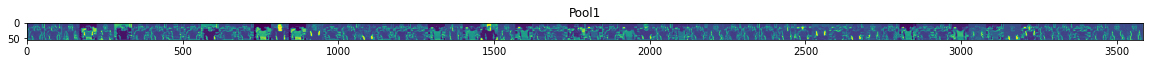

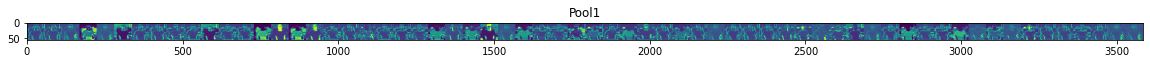

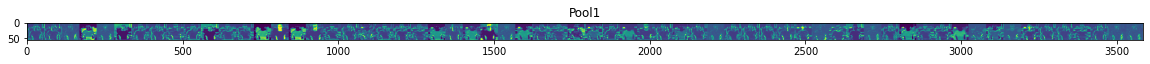

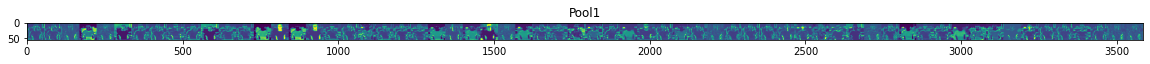

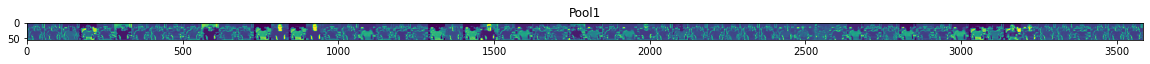

In [ ]:

#print(new_model.layers)
successive_outputs = [layer.output for layer in new_model.layers[:2]]
print(new_model.input)
visualization_model = tf.keras.models.Model(new_model.input, successive_outputs )
x = test_vid.reshape(1,16,112,112,3)
successive_feature_maps = visualization_model.predict(x)
layer_names = [layer.name for layer in new_model.layers]

for layer_name, feature_map in zip(layer_names, successive_feature_maps):

    if len(feature_map.shape) == 5:
        n_features = feature_map.shape[-1] 
        size=feature_map.shape[2]
        display_grid = np.zeros((size, size * n_features))
        for frame in range(16):
            for i in range(n_features):#n_features
              x  = feature_map[0, frame, :, :, i]
              x -= x.mean()
              x /= x.std ()
              x *=  64
              x += 128
              x  = np.clip(x, 0, 255).astype('uint8')
              # Tile each filter into a horizontal grid
              display_grid[:, i * size : (i + 1) * size] = x

            scale = 20. / n_features
            plt.figure(figsize=(scale * n_features, scale))#n_features
            plt.title (layer_name)
            plt.grid(False)
            plt.imshow(display_grid, aspect='auto', cmap='viridis')
            plt.savefig(f'/content/drive/MyDrive/feature_maps/maps{frame}{layer_name}.png',dpi=600)